# Jores et al 2021 Intepretation
**Authorship:**
Adam Klie, *08/12/2022*
***
**Description:**
Notebook to interpret the best trained models on the Jores et al dataset.
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import glob
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


/mnt/beegfs/users/aklie/projects/EUGENe/eugene/external/kipoi_veff/seqplotting_deps.py:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/mnt/beegfs/users/aklie/projects/EUGENe/eugene/external/kipoi_veff/seqplotting_deps.py:37: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


In [2]:
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene/jores21"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/jores21"
eu.settings.config_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/jores21"
figure_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/figures/jores21"
eu.settings.verbosity = logging.ERROR
eu.settings.batch_size = 128
eu.settings.dl_num_workers = 0

# Load in the `leaf`, `proto` and `combined` test `SeqData`s 

In [3]:
# Load in the preprocessed training data
sdata_leaf = eu.dl.read(os.path.join(eu.settings.output_dir, "leaf_test_predictions.h5sd"))
sdata_proto = eu.dl.read(os.path.join(eu.settings.output_dir, "proto_test_predictions.h5sd"))
sdata_combined = eu.dl.read(os.path.join(eu.settings.output_dir, "combined_test_predictions.h5sd"))
sdata_leaf, sdata_proto, sdata_combined

(SeqData object with = 7154 seqs
 seqs = (7154,)
 names = (7154,)
 rev_seqs = (7154,)
 ohe_seqs = (7154, 170, 4)
 ohe_rev_seqs = (7154, 170, 4)
 seqs_annot: 'GC', 'Jores21CNN_trial_1_enrichment_predictions', 'Jores21CNN_trial_2_enrichment_predictions', 'Jores21CNN_trial_3_enrichment_predictions', 'Jores21CNN_trial_4_enrichment_predictions', 'Jores21CNN_trial_5_enrichment_predictions', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'ssCNN_trial_1_enrichment_predictions', 'ssCNN_trial_2_enrichment_predictions', 'ssCNN_trial_3_enrichment_predictions', 'ssCNN_trial_4_enrichment_predictions', 'ssCNN_trial_5_enrichment_predictions', 'ssHybrid_trial_1_enrichment_predictions', 'ssHybrid_trial_2_enrichment_predictions', 'ssHybrid_trial_3_enrichment_predictions', 'ssHybrid_trial_4_enrichment_predictions', 'ssHybrid_trial_5_enrichment_predictions', 'start', 'strand', 'type'
 pos_annot: None
 seqsm: None
 uns: None,
 SeqData object with = 7595 seqs
 seqs 

# Load the best model

In [4]:
leaf_model_file = glob.glob(os.path.join(eu.settings.logging_dir, "ssHybrid", f"leaf_trial_5", "checkpoints", "*"))[0]
leaf_model = eu.models.Hybrid.load_from_checkpoint(leaf_model_file)
leaf_model

Hybrid(
  (hp_metric): R2Score()
  (convnet): BasicConv1D(
    (module): Sequential(
      (0): Conv1d(4, 256, kernel_size=(13,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.3, inplace=False)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Conv1d(256, 256, kernel_size=(13,), stride=(1,))
      (6): ReLU()
      (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Dropout(p=0.3, inplace=False)
      (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Conv1d(256, 256, kernel_size=(13,), stride=(1,))
      (11): ReLU()
      (12): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (13): Dropout(p=0.3, inplace=False)
      (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (recurren

In [5]:
proto_model_file = glob.glob(os.path.join(eu.settings.logging_dir, "Jores21CNN", f"proto_trial_5", "checkpoints", "*"))[0]
proto_model = eu.models.Jores21CNN.load_from_checkpoint(proto_model_file)
proto_model

Jores21CNN(
  (hp_metric): R2Score()
  (biconv): BiConv1D(
    (kernels): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 256x4x13]
        (1): Parameter containing: [torch.FloatTensor of size 256x256x13]
        (2): Parameter containing: [torch.FloatTensor of size 256x256x13]
    )
    (biases): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 256]
        (1): Parameter containing: [torch.FloatTensor of size 256]
        (2): Parameter containing: [torch.FloatTensor of size 256]
    )
  )
  (conv): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=same)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=43520, out_features=64, bias=True)
  (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [6]:
combined_model_file = glob.glob(os.path.join(eu.settings.logging_dir, "Jores21CNN", f"combined_trial_3", "checkpoints", "*"))[0]
combined_model = eu.models.Jores21CNN.load_from_checkpoint(combined_model_file)
combined_model

Jores21CNN(
  (hp_metric): R2Score()
  (biconv): BiConv1D(
    (kernels): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 256x4x13]
        (1): Parameter containing: [torch.FloatTensor of size 256x256x13]
        (2): Parameter containing: [torch.FloatTensor of size 256x256x13]
    )
    (biases): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 256]
        (1): Parameter containing: [torch.FloatTensor of size 256]
        (2): Parameter containing: [torch.FloatTensor of size 256]
    )
  )
  (conv): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=same)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=43520, out_features=64, bias=True)
  (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [7]:
# Choose which model you want to use
name = "proto"
model = proto_model
sdata = sdata_proto

## Feature attribution

In [8]:
saliency_methods = ["InputXGradient", "DeepLift", "GradientSHAP"]
for method in saliency_methods:
    eu.interpret.feature_attribution(
        model,
        sdata,
        saliency_method=method
    )

No transforms given, assuming just need to tensorize).


Computing saliency on batches:   0%|          | 0/59 [00:00<?, ?it/s]

No transforms given, assuming just need to tensorize).


Computing saliency on batches:   0%|          | 0/59 [00:00<?, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:339: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


No transforms given, assuming just need to tensorize).


Computing saliency on batches:   0%|          | 0/59 [00:00<?, ?it/s]

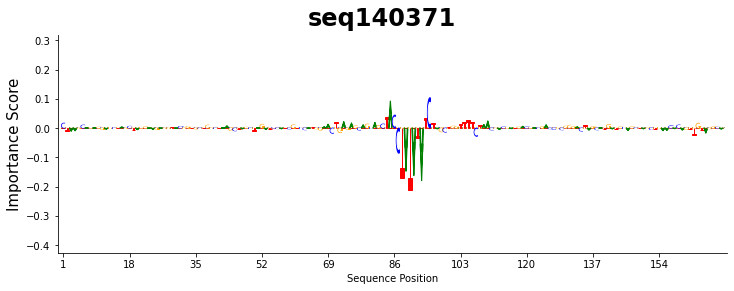

In [9]:
eu.pl.seq_track(
    sdata,
    seq_id=sdata.names[0],
    uns_key="InputXGradient_imps"
)

In [10]:
bottom3 = sdata["ssHybrid_trial_5_enrichment_predictions"].sort_values().iloc[:3].index
top3 = sdata["ssHybrid_trial_5_enrichment_predictions"].sort_values().iloc[-3:].index

Importance values: 0it [00:00, ?it/s]

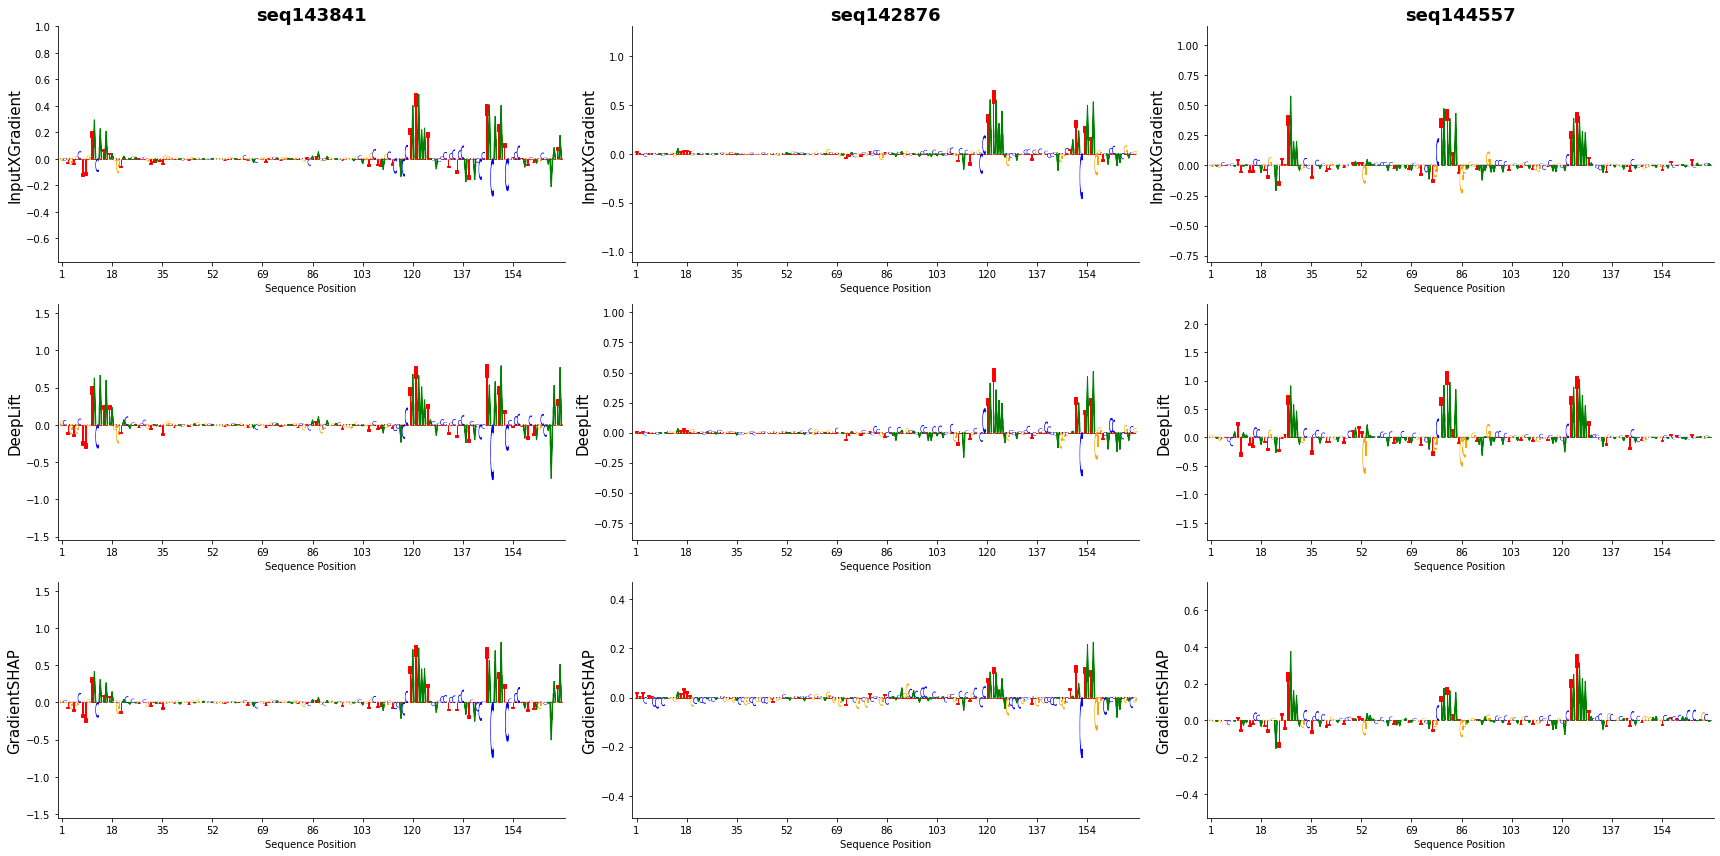

In [11]:
eu.pl.multiseq_track(
    sdata,
    seq_ids=top3,
    uns_keys = [method + "_imps" for method in saliency_methods],
    ylabels=saliency_methods,
    save=os.path.join(figure_dir, f"{name}_best_model_top3_feature_attr.pdf")
)

Importance values: 0it [00:00, ?it/s]

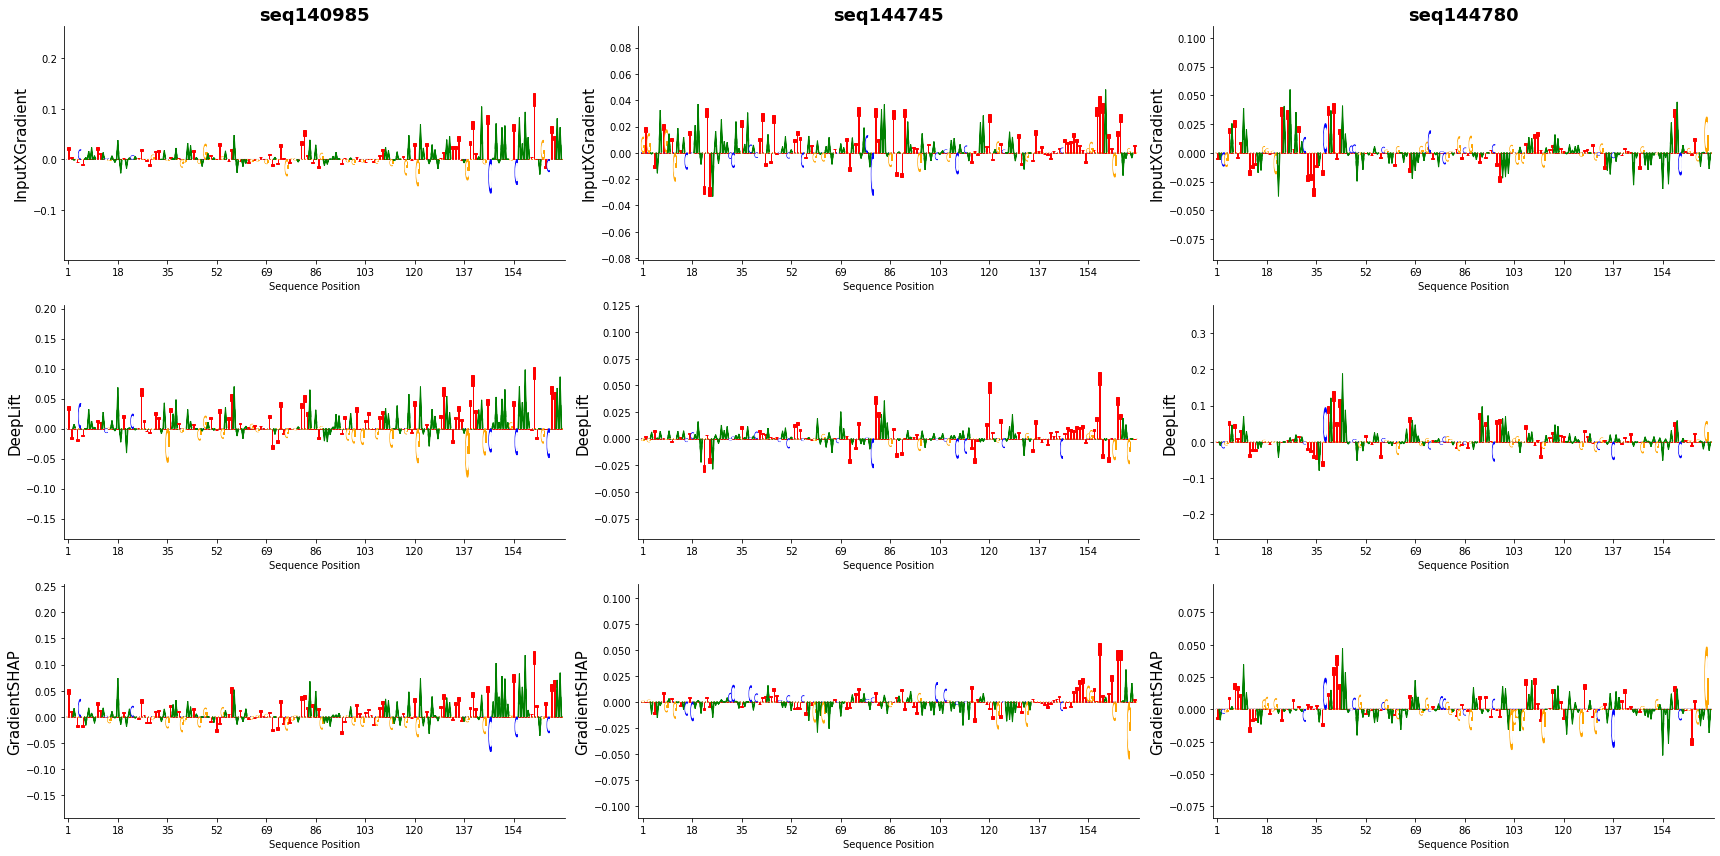

In [12]:
eu.pl.multiseq_track(
    sdata,
    seq_ids=bottom3,
    uns_keys = [method + "_imps" for method in saliency_methods],
    ylabels=saliency_methods,
    save=os.path.join(figure_dir, f"{name}_best_model_bottom3_feature_attr.pdf")
)

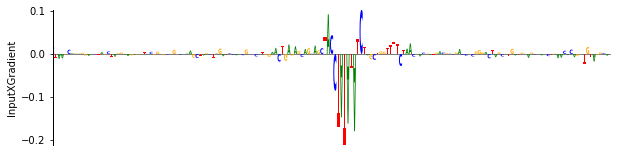

In [13]:
eu.pl.lm_seq_track(
    sdata,
    seq_id=sdata.names[0],
    uns_key="InputXGradient_imps",
    ylabel="InputXGradient",
)

Importance values: 0it [00:00, ?it/s]

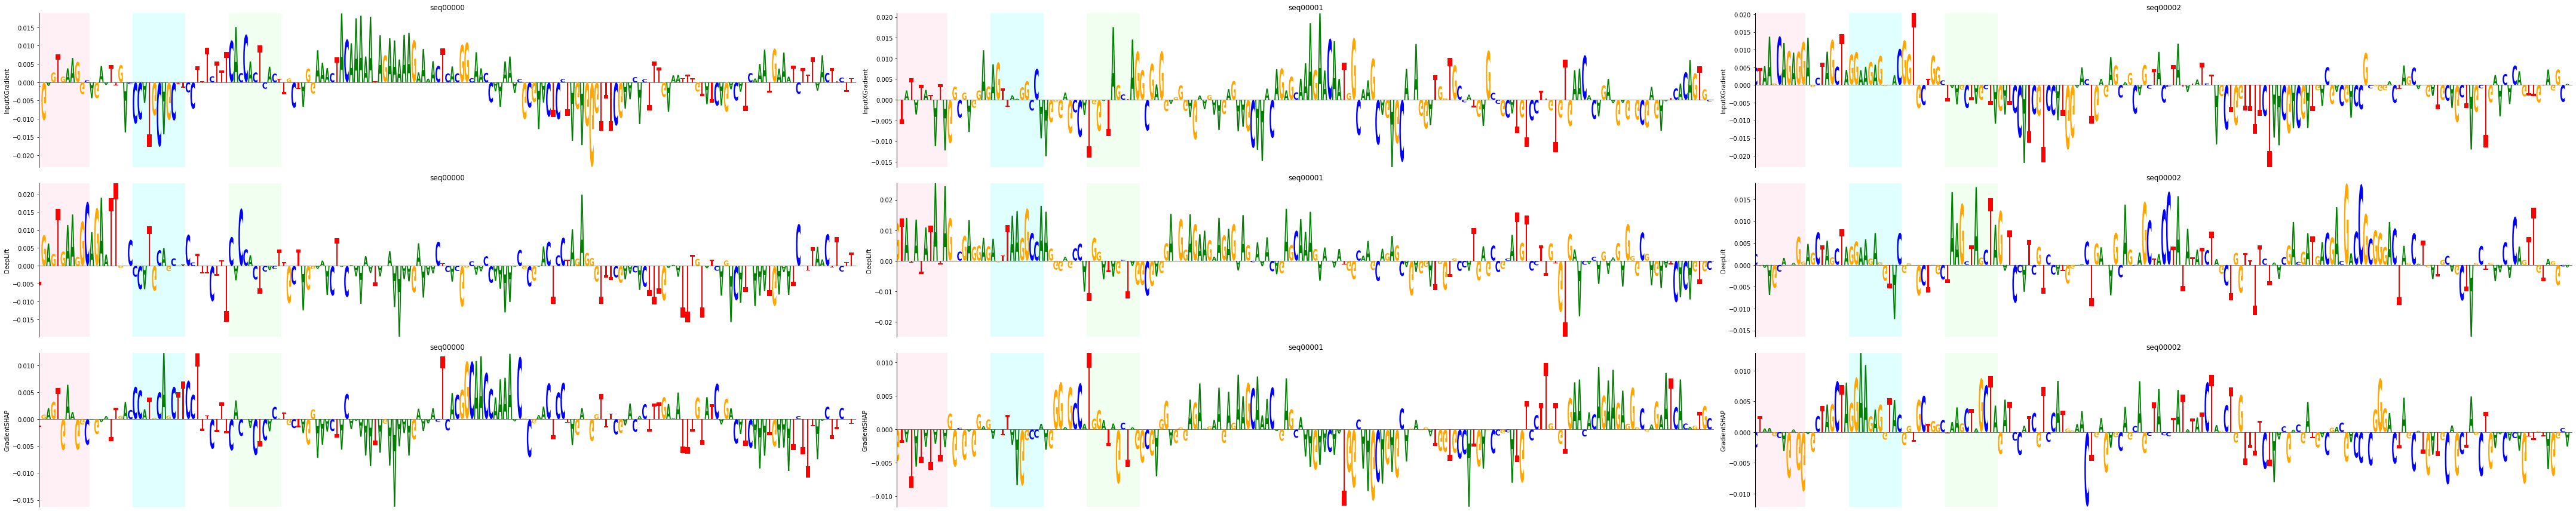

In [8]:
eu.pl.lm_multiseq_track(
    sdata,
    seq_ids=sdata.names[:3],
    uns_keys = [method + "_imps" for method in saliency_methods],
    ylabels=saliency_methods,
    highlights=[(0, 10), (20, 30), (40, 50)], 
    width=60, 
    height=12,
)

Importance values: 0it [00:00, ?it/s]

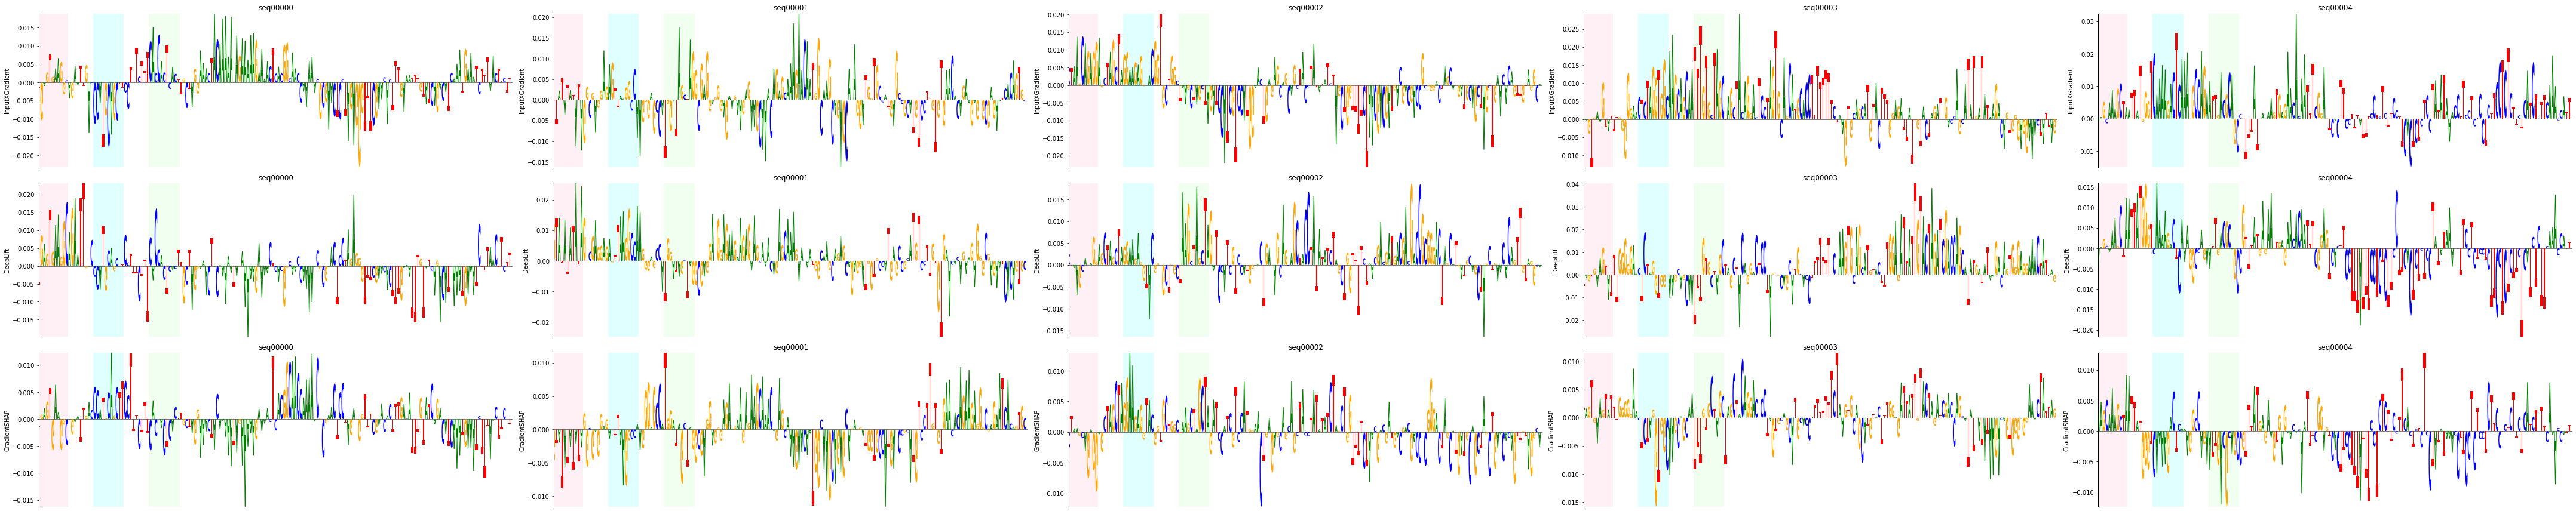

In [17]:
lm_multiseq_track(
    sdata, 
    seq_ids=sdata.names[:5],
    uns_keys = [method + "_imps" for method in saliency_methods],
    ylabels=saliency_methods,
    highlights=[(0, 10), (20, 30), (40, 50)], 
    width=60, 
    height=12,
    save=os.path.join(eu.settings.output_dir, "{name}_saliency_track.pdf")
)

## Filter viz

In [14]:
model.to("cuda") #TODO
eu.interpret.generate_pfms(model, sdata)

No transforms given, assuming just need to tensorize).


Getting maximial activating seqlets:   0%|          | 0/59 [00:00<?, ?it/s]

Getting PFMs from filters:   0%|          | 0/256 [00:00<?, ?it/s]

Plotting and saving filters 1-32
Plotting and saving filters 33-64
Plotting and saving filters 65-96
Plotting and saving filters 97-128
Plotting and saving filters 129-160
Plotting and saving filters 161-192
Plotting and saving filters 193-224
Plotting and saving filters 225-256


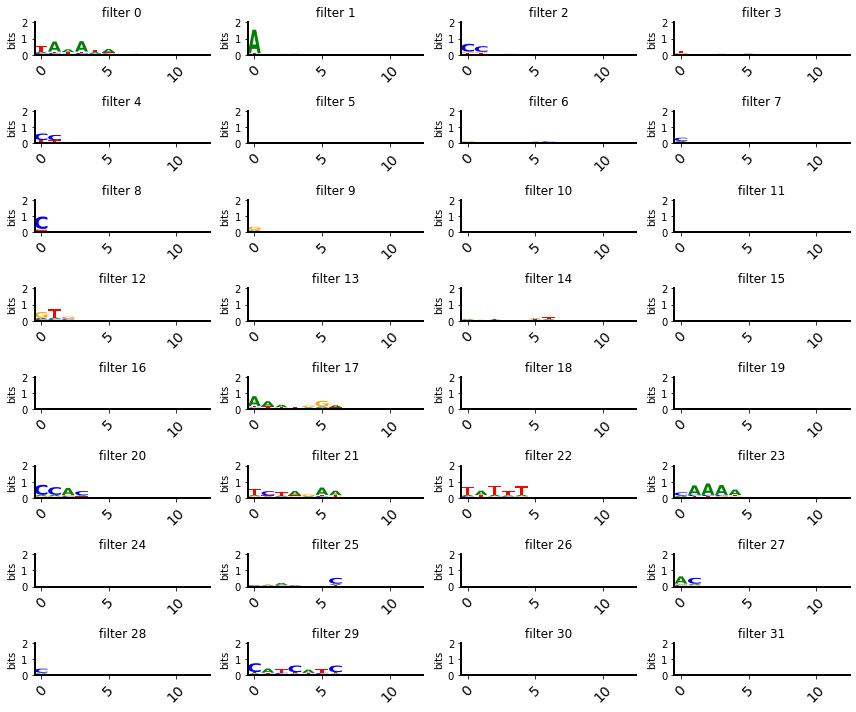

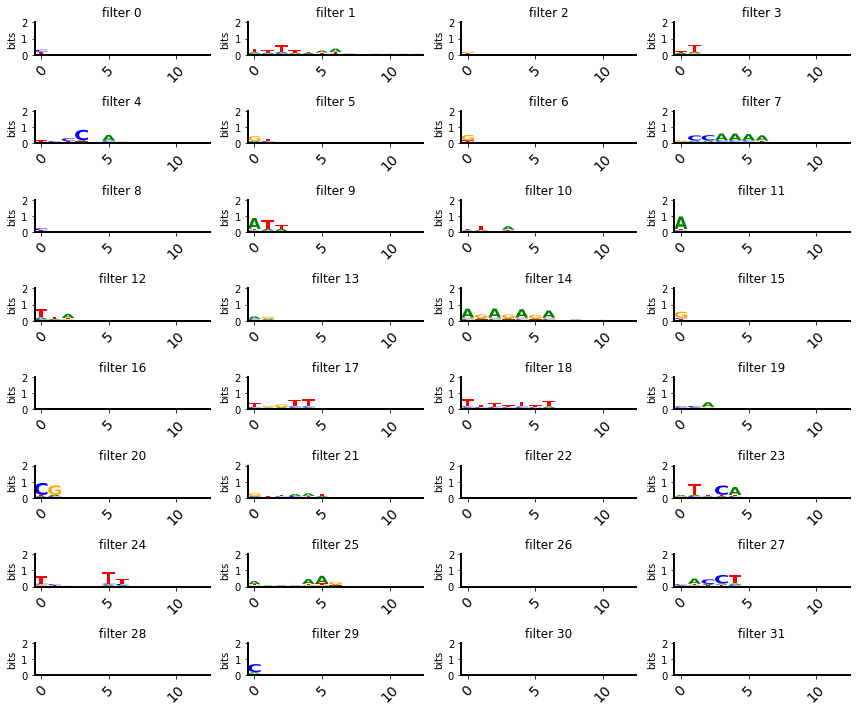

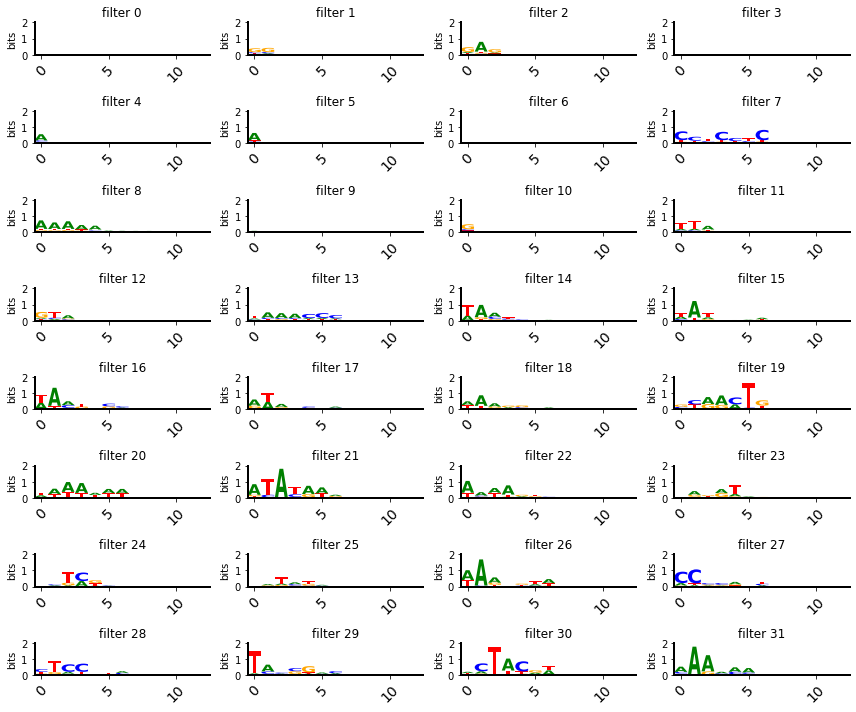

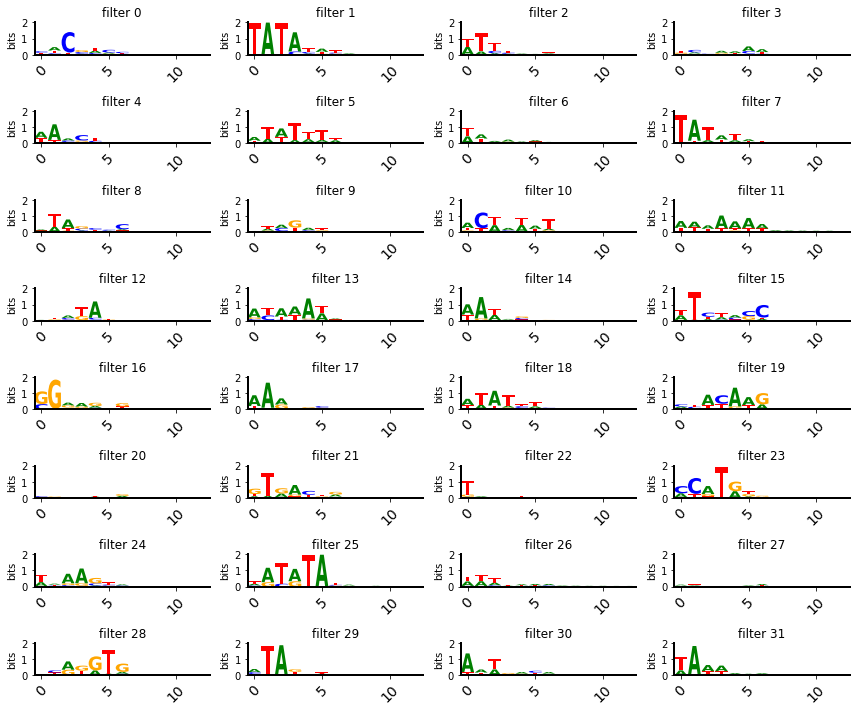

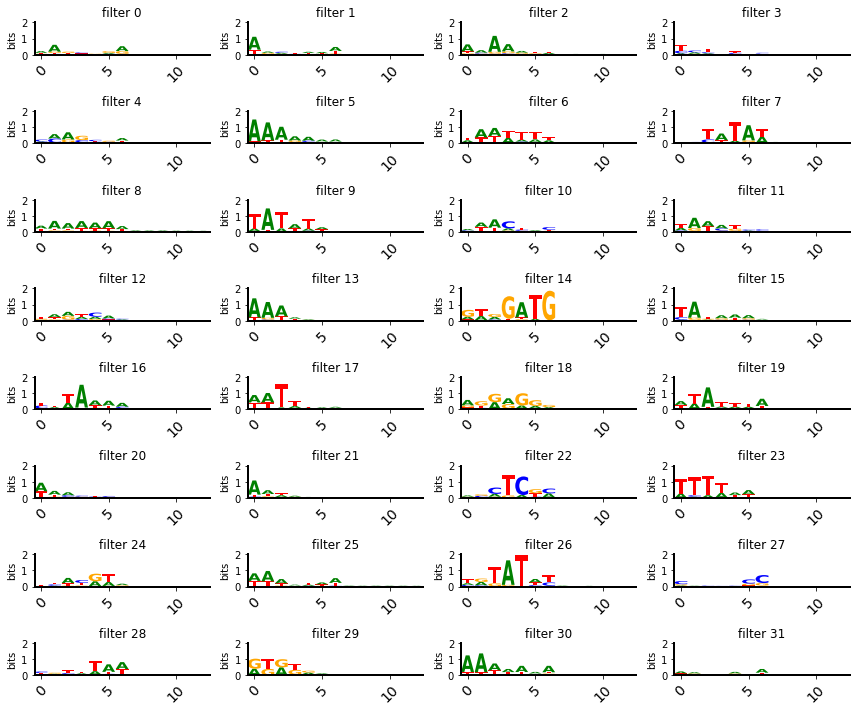

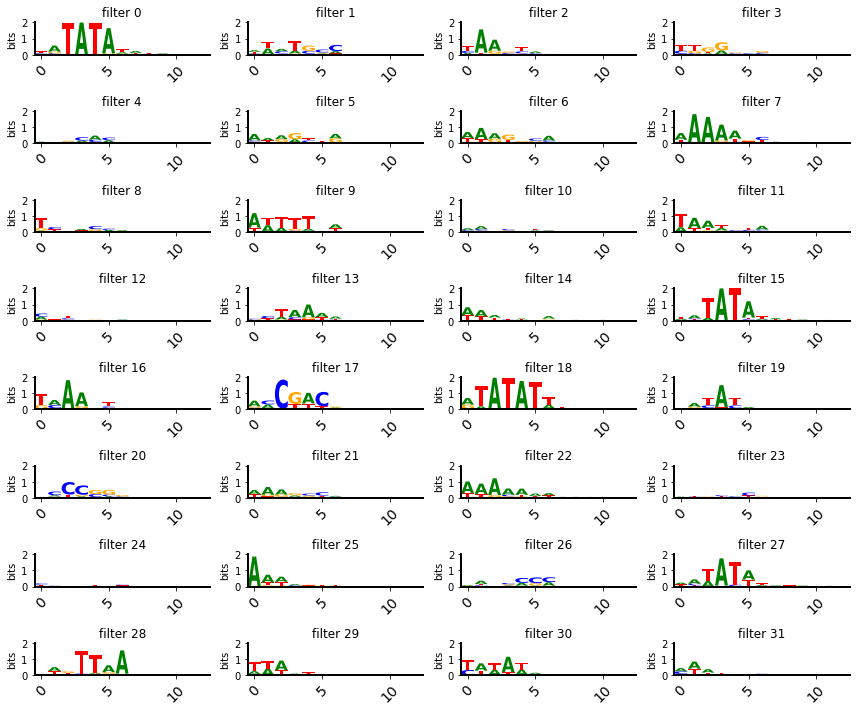

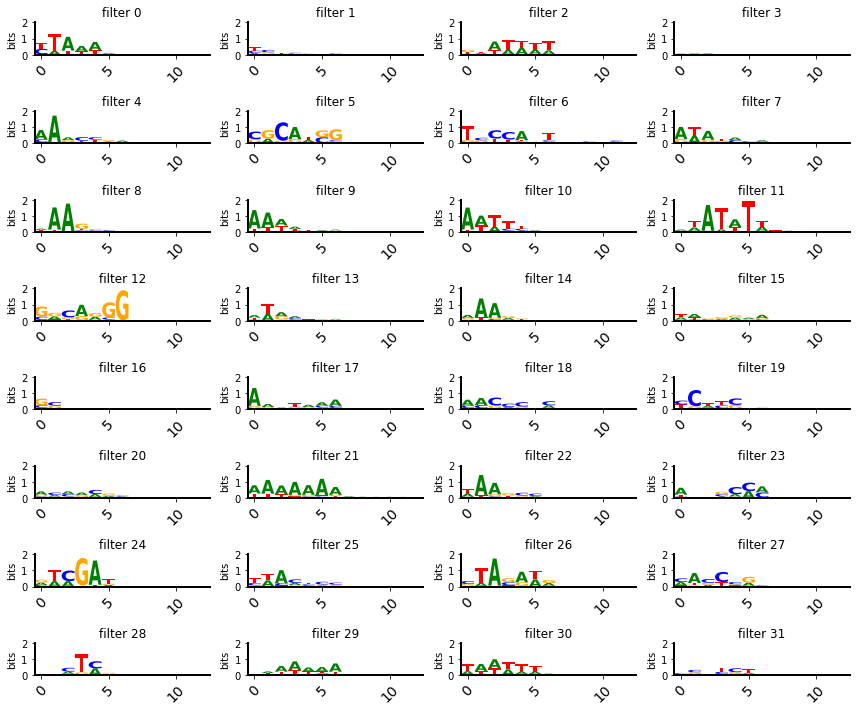

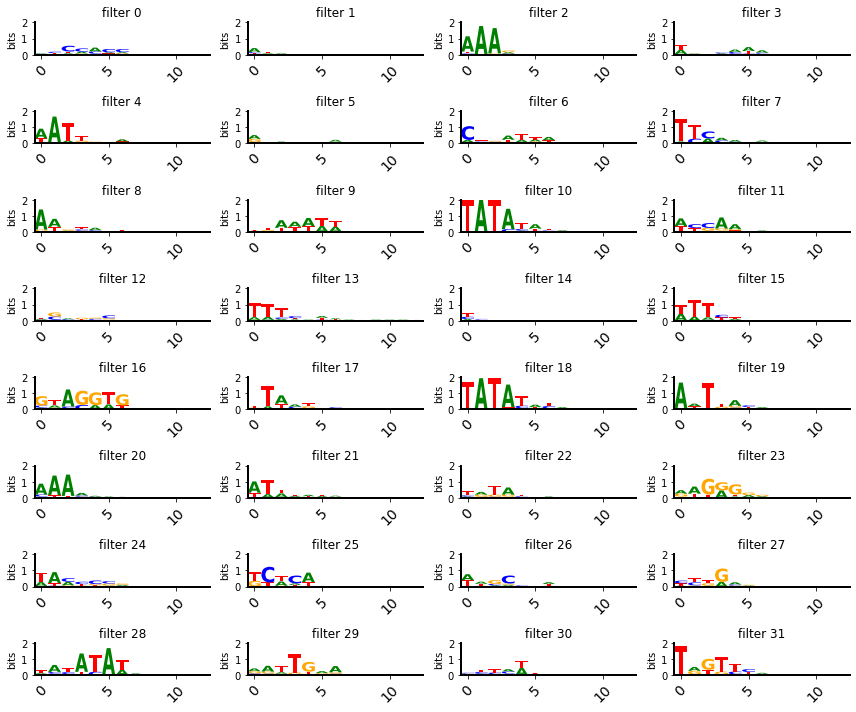

In [15]:
# TODO: turn into a function that plots all the filters in groups specified by user
for i in range(8):
    start_filter = i*32
    end_filter = (i*32) + 32
    print(f"Plotting and saving filters {start_filter+1}-{end_filter}")
    eu.pl.lm_multifilter_viz(
        sdata,
        filter_ids=list(sdata.uns["pfms"].keys())[start_filter:end_filter],
        num_rows=8,
        num_cols=4,
        titles=[f"filter {i}" for i in range(32)],
        save=os.path.join(figure_dir, f"{name}_best_model_filters{start_filter+1}-{end_filter}_viz.pdf")
    )

In [16]:
sdata

SeqData object with = 7595 seqs
seqs = (7595,)
names = (7595,)
rev_seqs = (7595,)
ohe_seqs = (7595, 170, 4)
ohe_rev_seqs = (7595, 170, 4)
seqs_annot: 'GC', 'Jores21CNN_trial_1_enrichment_predictions', 'Jores21CNN_trial_2_enrichment_predictions', 'Jores21CNN_trial_3_enrichment_predictions', 'Jores21CNN_trial_4_enrichment_predictions', 'Jores21CNN_trial_5_enrichment_predictions', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'ssCNN_trial_1_enrichment_predictions', 'ssCNN_trial_2_enrichment_predictions', 'ssCNN_trial_3_enrichment_predictions', 'ssCNN_trial_4_enrichment_predictions', 'ssCNN_trial_5_enrichment_predictions', 'ssHybrid_trial_1_enrichment_predictions', 'ssHybrid_trial_2_enrichment_predictions', 'ssHybrid_trial_3_enrichment_predictions', 'ssHybrid_trial_4_enrichment_predictions', 'ssHybrid_trial_5_enrichment_predictions', 'start', 'strand', 'type'
pos_annot: None
seqsm: None
uns: 'InputXGradient_imps', 'DeepLift_imps', 'GradientSHAP_i

In [17]:
sdata.write_h5sd(os.path.join(eu.settings.output_dir, f"{name}_test_predictions_and_interpretations.h5sd"))

## In silico interpretation

In [52]:
sdata_evolve = eu.dl.read_csv(os.path.join(eu.settings.dataset_dir, "promoters_for_evolution.tsv"), seq_col="sequence", name_col="name")
sdata_evolve

SeqData object with = 310 seqs
seqs = (310,)
names = (310,)
rev_seqs = None
ohe_seqs = None
ohe_rev_seqs = None
seqs_annot: 'target'
pos_annot: None
seqsm: None
uns: None

In [53]:
eu.pp.one_hot_encode_data(sdata_evolve)

One-hot-encoding sequences:   0%|          | 0/310 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 310 ohe_seqs added


In [54]:
model.to("cuda") #TODO

Hybrid(
  (hp_metric): R2Score()
  (convnet): BasicConv1D(
    (module): Sequential(
      (0): Conv1d(4, 256, kernel_size=(13,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.3, inplace=False)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Conv1d(256, 256, kernel_size=(13,), stride=(1,))
      (6): ReLU()
      (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Dropout(p=0.3, inplace=False)
      (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Conv1d(256, 256, kernel_size=(13,), stride=(1,))
      (11): ReLU()
      (12): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (13): Dropout(p=0.3, inplace=False)
      (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (recurren

In [55]:
eu.interpret.evolve_sdata(
    model,
    sdata_evolve,
    rounds=3
)
eu.interpret.evolve_sdata(
    model,
    sdata_evolve,
    rounds=5
)
eu.interpret.evolve_sdata(
    model,
    sdata_evolve,
    rounds=10
)

cuda


Evolving seqs:   0%|          | 0/310 [00:00<?, ?it/s]

cuda


Evolving seqs:   0%|          | 0/310 [00:00<?, ?it/s]

cuda


Evolving seqs:   0%|          | 0/310 [00:00<?, ?it/s]

In [58]:
sdata_evolve

SeqData object with = 310 seqs
seqs = (310,)
names = (310,)
rev_seqs = None
ohe_seqs = (310, 170, 4)
ohe_rev_seqs = None
seqs_annot: 'target', 'original_scores', 'evolved_3_scores', 'evolved_5_scores', 'evolved_10_scores'
pos_annot: None
seqsm: None
uns: None

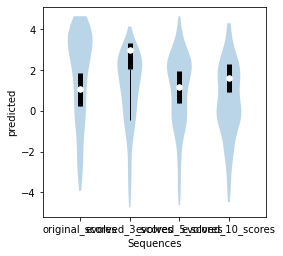

In [59]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sequences')
    ax.set_ylabel('predicted')

keys=["original_scores", "evolved_3_scores", "evolved_5_scores", "evolved_10_scores"]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), sharey=True)
data = sdata_evolve.seqs_annot[keys].values
parts = ax.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False)

quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
set_axis_style(ax, keys)

plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()

In [64]:
import seaborn as sns

In [80]:
def violin_long(
    sdata,
    groups,
    xlabel="variable",
    ylabel="value",
    save=None
):
    if isinstance(groups, str):
        groups=[groups]
    long_evolve = sdata.seqs_annot.melt(value_vars=groups)
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    sns.violinplot(data=long_evolve, x="variable", y="value", ax=ax)
    sns.stripplot(data=long_evolve, x="variable", y="value", color="black", ax=ax)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    if save:
        plt.savefig(save)

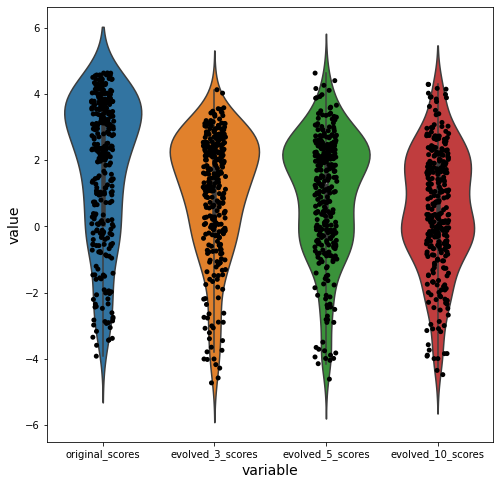

In [81]:
violin_long(
    sdata_evolve, 
    groups=["original_scores", "evolved_3_scores", "evolved_5_scores", "evolved_10_scores"], 
    save=os.path.join(figure_dir, f"{name}_best_model_evolution_summary.pdf")
)

---

# Scratch

In [ ]:
import logomaker as lm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def lm_seq_track(
    sdata,
    seq_id=None,
    uns_key=None,
    highlights: list = [],
    highlight_colors: list = ["lavenderblush", "lightcyan", "honeydew"],
    ylabel = "Saliency",
    title="",
    return_ax: bool = False,
    save=None,
    **kwargs
):
    if isinstance(highlight_colors, str):
        highlight_colors = [highlight_colors] * len(highlights)

    # Get the sequence and annotations
    seq_idx = np.where(sdata.seqs_annot.index == seq_id)[0][0]
    seq = sdata.seqs[seq_idx]
    imp_scores = sdata.uns[uns_key][seq_idx] if uns_key in sdata.uns.keys() else None
    viz_seq = pd.DataFrame(imp_scores.T, columns=["A", "C", "G", "T"])
    viz_seq.index.name = "pos"
    y_max = np.max(viz_seq.values)
    y_min = np.min(viz_seq.values)
    nn_logo = lm.Logo(
        viz_seq,
        **kwargs
    )

    # style using Logo methods
    nn_logo.style_spines(visible=False)
    nn_logo.style_spines(spines=['left'], visible=True, bounds=[y_min, y_max])

    # style using Axes methods
    nn_logo.ax.set_xlim([0, len(viz_seq)])
    nn_logo.ax.set_xticks([])
    nn_logo.ax.set_ylim([y_min, y_max])
    nn_logo.ax.set_ylabel(ylabel)
    nn_logo.ax.set_title(title)
    for i, highlight in enumerate(highlights):
        nn_logo.highlight_position_range(pmin=highlight[0], pmax=highlight[1], color=highlight_colors[i])
    if return_ax:
        return nn_logo.ax
    if save is not None:
        plt.savefig(save)


def lm_multiseq_track(
    sdata,
    seq_ids: list,
    uns_keys: str = None,
    ylabels: list = None,
    width=None,
    height=None,
    return_axes: bool = False,
    save: str = None,
    **kwargs
):
    if isinstance(seq_ids, str):
        seq_ids = [seq_ids]
    if isinstance(uns_keys, str):
        uns_keys = [uns_keys]
    if isinstance(ylabels, str):
        ylabels = [ylabels]
    ylabels = ylabels if ylabels is not None else ["Importance Score"] * len(uns_keys)
    fig_width = len(seq_ids) * int(170 / 20) if width is None else width # make each sequence width proportional to its length and multiply by the number of sequences
    fig_height = len(uns_keys)*4 if height is None else height # make each sequence height proportional to the number of uns_keys
    _, ax = plt.subplots(len(uns_keys), len(seq_ids), figsize=(fig_width, fig_height))
    for i, uns_key in tqdm(enumerate(uns_keys), desc=f"Importance values", position=0):
        for j, seq_id in enumerate(seq_ids):
            lm_seq_track(
                sdata,
                seq_id=seq_id,
                uns_key=uns_key,
                ax=ax.flatten()[i*len(seq_ids)+j],
                ylabel=ylabels[i],
                title=seq_id,
                save=None,
                **kwargs
            )

    plt.tight_layout()
    if return_axes:
        return ax
    if save is not None:
        plt.savefig(save)

In [ ]:
import matplotlib.pyplot as plt
from eugene.plotting._seq import _plot_seq_logo
from tqdm.auto import tqdm
uns_keys = [method + "_imps" for method in ["InputXGradient", "DeepLift", "GradientSHAP", "NaiveISM"]]
ylabels = ["InputXGradient", "DeepLift", "GradientSHAP", "NaiveISM"]
seq_id = sdata.names[:2]
if isinstance(seq_id, str):
    seq_id = [seq_id]
if isinstance(uns_keys, str):
    uns_keys = [uns_keys]
seq_idx = np.where(sdata.seqs_annot.index.isin(seq_id))[0]
seqs = sdata.seqs[seq_idx]
print(seq_id, uns_keys, seq_idx, seqs)
fig_width = len(seq_id) * int(len(seqs[0]) / 20) # make each sequence width proportional to its length and multiply by the number of sequences
fig_height = len(uns_keys)*6
_, ax = plt.subplots(len(uns_keys), len(seq_id), figsize=(fig_width, fig_height))
for i, uns_key in tqdm(enumerate(uns_keys), desc=f"Importance values", position=0):
    for j, seq in tqdm(enumerate(seqs), desc=f"Plotting sequence", position=1):
        imp_scores = sdata.uns[uns_key][seq_idx[j]] if uns_key in sdata.uns.keys() else None
        _plot_seq_logo(
            ax.flatten()[i*len(seq_id)+j],
            seq,
            imp_scores=imp_scores,
            ylab=ylabels[i],
        )
        if i == 0:
            print(j*len(uns_keys))
            ax.flatten()[i*len(seq_id)+j].set_title(seq_id[j], fontsize=18, weight="bold")
plt.tight_layout()

In [ ]:
cpm = seqlogo.CompletePm(pfm=sdata_leaf.uns["pfms"][0])
print(cpm)
scaled_cpm = cpm.ppm.multiply(cpm.ic, axis=0)
logo = seqlogo.seqlogo(cpm, ic_scale=True, format="png")
display(logo)

In [ ]:
info_mat = logomaker.transform_matrix(pfm, 
                                      from_type='counts', 
                                      to_type='information')                                      
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12,10))
for i in range(num_rows):
    for j in range(num_cols):
        filter_id = filter_ids[i*num_cols+j]
        pfm=sdata_leaf.uns["pfms"][filter_id]
        info_mat = logomaker.transform_matrix(
            pfm, 
            from_type='counts', 
            to_type='information')
        logo = logomaker.Logo(
            info_mat,
            font_name = 'Arial Rounded MT Bold',
            ax=ax[i,j])
        logo.style_xticks(spacing=5, anchor=25, rotation=45, fmt='%d', fontsize=14)
        logo.style_spines(visible=False)
        logo.style_spines(spines=['left','bottom'], visible=True, linewidth=2)

        logo.ax.set_ylim([0, 2])
        logo.ax.set_yticks([0, 1, 2])
        logo.ax.set_yticklabels(['0', '1', '2'])
        logo.ax.set_ylabel('bits')
plt.tight_layout()
plt.savefig('../../_output/jores21/pfms.pdf')

In [ ]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12,10))
for i in range(num_rows):
    for j in range(num_cols):
        ax[i,j].imshow(imread(os.path.join(eu.settings.output_dir, "fig", f"leaf_filter_{i*num_cols+j}.png")))
        #ax[i,j].axis('off')
#plt.savefig(os.path.join(eu.settings.output_dir, "fig", "leaf_filters.pdf"))

In [ ]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    fig = figure(figsize=(20,10))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        axis('off')

import glob
showImagesHorizontally(glob.glob("../../_output/jores21/fig/*filter*.png"))

In [ ]:
for filter_id in filter_ids:
    pfm=sdata_leaf.uns["pfms"][filter_id]
    cpm = seqlogo.CompletePm(pfm=pfm)
    logo = seqlogo.seqlogo(
        cpm, 
        ic_scale=True, 
        format="png", 
        size="xlarge",
        filename=os.path.join(eu.settings.output_dir, "fig", f"leaf_filter_{filter_id}.png")
    )
    

No importance scores given, outputting just sequence
No importance scores given, outputting just sequence


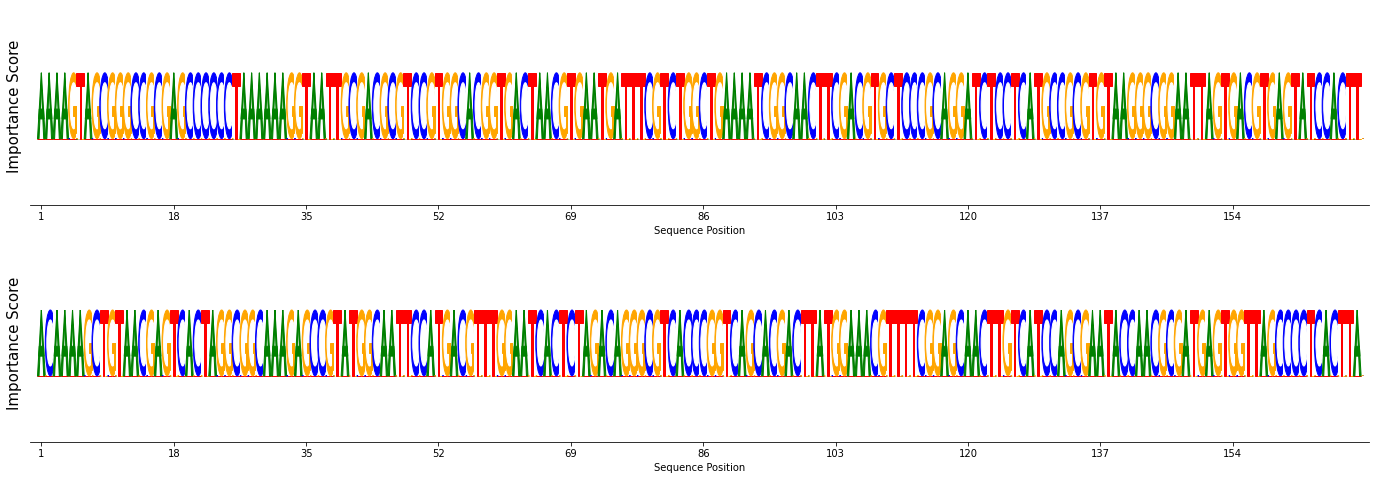

In [ ]:
from eugene.plotting._seq import _plot_seq_logo
fig, ax = plt.subplots(2, 1, figsize=(24, 8))
_plot_seq_logo(ax[1], sdata_evolve.seqs[10])
_plot_seq_logo(ax[0], eu.pp.decode_DNA_seq(evolved_seq[0]))